### 加载h5py 模块
* 利用h5py.File()函数读取h5文件，文件结构类似dict
* 利用keys()函数获取File的所有键值
* 获取File相应键值的value——dataset

In [1]:
import h5py

f = h5py.File('E:/Alibaba German AI Challenge/round1_test_a_20181109.h5','r')

type(f)

h5py._hl.files.File

In [2]:
list(f.keys())

['sen1', 'sen2']

In [3]:
sen1 = f['sen1']
sen2 = f['sen2']
type(sen1)

h5py._hl.dataset.Dataset

In [4]:
sen1.shape,sen2.shape

((4838, 32, 32, 8), (4838, 32, 32, 10))

In [5]:
sen1.size

39632896

In [6]:
sen1.dtype

dtype('float64')

##### dataset类型的属性
* shape
* size
* dtype

In [7]:
import numpy as np

s1 = np.array(sen1)
s1.shape

(4838, 32, 32, 8)

##### load validation data

In [1]:
import h5py

f = h5py.File('E:/Alibaba German AI Challenge/origin_DATA/validation.h5','r')

type(f)

h5py._hl.files.File

In [2]:
list(f.keys())

['label', 'sen1', 'sen2']

In [2]:
import numpy as np
s1 = np.array(f['sen1'])
s2 = np.array(f['sen2'])
y = np.array(f['label'])
s1.shape,s2.shape,y.shape

((24119, 32, 32, 8), (24119, 32, 32, 10), (24119, 17))

In [3]:
x = []
for i in range(0,s1.shape[0]):
    temp1 = s1[i].flatten()
    temp2 = s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    x.append(temp)
x = np.array(x)
x.shape

(24119, 18432)

In [4]:
data = np.hstack((x,y))
data.shape

(24119, 18449)

##### CNN demo

In [1]:
# start tensorflow interactiveSession              baseline                 accuracy = 0.702                
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/origin_DATA/validation.h5'
f = h5py.File(filename,'r')
print('Get the h5 file')

s1 = np.array(f['sen1'])
s2 = np.array(f['sen2'])
y = np.array(f['label'])

x = []
for i in range(0,s1.shape[0]):
    temp1 = s1[i].flatten()
    temp2 = s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    x.append(temp)
x = np.array(x)

data = np.hstack((x,y))
print('The shape of data is ',data.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])


# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 32, 32, 18])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.GradientDescentOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y


batch_size = 200
for i in range(64000):
    batch_x,batch_y = get_batch(data,batch_size)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g" %(i, train_accuracy))
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})


Get the h5 file
The shape of data is  (24119, 18449)


TypeError: unhashable type: 'numpy.ndarray'

In [2]:
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
list(f.keys())

['sen1', 'sen2']

In [3]:
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)
test.shape

(4838, 18432)

In [4]:
test_y = np.zeros((test.shape[0],17))
test_y.shape

(4838, 17)

In [6]:
pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])
P

array([16,  2, 13, ...,  8, 13, 16], dtype=int64)

In [7]:
P.shape

(4838,)

In [11]:
one_hot=tf.one_hot(P,17)
one_hot.shape

TensorShape([Dimension(4838), Dimension(17)])

In [12]:
one_hot

<tf.Tensor 'one_hot_1:0' shape=(4838, 17) dtype=float32>

In [20]:
Pred_one_hot = sess.run(one_hot)

In [15]:
Pred_one_hot.shape

(4838, 17)

In [21]:
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
out.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
Pred_one_hot = Pred_one_hot.astype(np.int32)

In [23]:
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
out.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [24]:
out.shape

(4838, 17)

In [25]:
out.to_csv('first_64k_vali_as_train.csv', index = False, header = False)

##### 挖掘该套策略的全部

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random

filename = 'E:/Alibaba German AI Challenge/data_process/vali_data.npy'

vali = np.load('E:/Alibaba German AI Challenge/data_process/sample_of_training_10k.npy')
data = np.load(filename)
print('The shape of data is ',data.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])


# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 32, 32, 18])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
Eval = []

batch_size = 300
for i in range(40000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    loss_temp = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(loss_temp)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        Eval.append(train_accuracy)
        print ("step %d, train accuracy %g, train loss %f" %(i, train_accuracy, loss_temp))


The shape of data is  (24119, 18449)
step 0, train accuracy 0.0862, train loss 3501.060547
step 200, train accuracy 0.4461, train loss 799.105713
step 400, train accuracy 0.4806, train loss 627.051941
step 600, train accuracy 0.4695, train loss 622.606873
step 800, train accuracy 0.4913, train loss 527.536499
step 1000, train accuracy 0.4936, train loss 395.613281
step 1200, train accuracy 0.5007, train loss 447.039459
step 1400, train accuracy 0.5109, train loss 371.680420
step 1600, train accuracy 0.5092, train loss 365.894165
step 1800, train accuracy 0.5167, train loss 327.782471
step 2000, train accuracy 0.5172, train loss 310.625122
step 2200, train accuracy 0.5187, train loss 343.159912
step 2400, train accuracy 0.5199, train loss 317.177368
step 2600, train accuracy 0.5196, train loss 298.385986
step 2800, train accuracy 0.5222, train loss 307.308716
step 3000, train accuracy 0.5177, train loss 290.503601
step 3200, train accuracy 0.5262, train loss 303.264313
step 3400, train 

step 29400, train accuracy 0.5348, train loss 0.323528
step 29600, train accuracy 0.5333, train loss 0.361449
step 29800, train accuracy 0.5247, train loss 0.311414
step 30000, train accuracy 0.5379, train loss 0.442805
step 30200, train accuracy 0.5312, train loss 0.410918
step 30400, train accuracy 0.5373, train loss 0.450604
step 30600, train accuracy 0.5227, train loss 0.862874
step 30800, train accuracy 0.5293, train loss 16.504375
step 31000, train accuracy 0.5274, train loss 16.497541
step 31200, train accuracy 0.532, train loss 16.425076
step 31400, train accuracy 0.5359, train loss 16.455519
step 31600, train accuracy 0.5395, train loss 32.689018
step 31800, train accuracy 0.5364, train loss 0.376679
step 32000, train accuracy 0.5234, train loss 0.419510
step 32200, train accuracy 0.5383, train loss 0.175797
step 32400, train accuracy 0.5279, train loss 0.235509
step 32600, train accuracy 0.5287, train loss 0.769063
step 32800, train accuracy 0.5296, train loss 0.132920
step 3

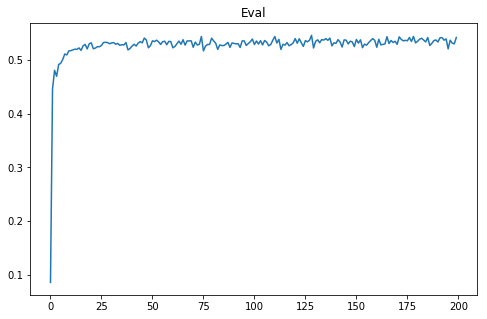

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,Eval)
plt.title('Eval')
plt.show()

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.11      0.04      0.06       157
          1       0.33      0.35      0.34       710
          2       0.44      0.33      0.38       858
          3       0.14      0.25      0.18       254
          4       0.28      0.18      0.22       492
          5       0.38      0.19      0.25       956
          6       0.01      0.01      0.01        80
          7       0.56      0.65      0.60      1092
          8       0.20      0.33      0.25       389
          9       0.21      0.12      0.16       323
         10       0.70      0.90      0.79      1230
         11       0.38      0.14      0.21       264
         12       0.04      0.02      0.03       268
         13       0.61      0.76      0.68      1186
         14       0.19      0.08      0.11        65
         15       0.44      0.55      0.49       251
         16       0.94      0.97      0.96      1425

avg / total       0.51      0.53      0.51  

In [4]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

out.to_csv('forth_40k_batch_vali_Adam.csv', index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random

filename = 'E:/Alibaba German AI Challenge/data_process/vali_data.npy'

vali = np.load('E:/Alibaba German AI Challenge/data_process/sample_of_training_10k.npy')
data = np.load(filename)
print('The shape of data is ',data.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])


# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 32, 32, 18])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
Eval = []

batch_size = 1000
for i in range(12000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    loss_temp = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(loss_temp)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, train loss %f" %(i, train_accuracy, loss_temp))


The shape of data is  (24119, 18449)
step 0, train accuracy 0.086, train loss 10549.526367
step 100, train accuracy 0.485, train loss 3021.301758
step 200, train accuracy 0.51, train loss 2443.161133
step 300, train accuracy 0.532, train loss 1890.379150
step 400, train accuracy 0.559, train loss 1780.113770
step 500, train accuracy 0.557, train loss 1665.154541
step 600, train accuracy 0.586, train loss 1497.526367
step 700, train accuracy 0.614, train loss 1369.020996
step 800, train accuracy 0.599, train loss 1304.535645
step 900, train accuracy 0.613, train loss 1302.531250
step 1000, train accuracy 0.654, train loss 1196.070557
step 1100, train accuracy 0.661, train loss 1213.286011
step 1200, train accuracy 0.683, train loss 1136.839600
step 1300, train accuracy 0.68, train loss 1048.243896
step 1400, train accuracy 0.698, train loss 1019.251892
step 1500, train accuracy 0.677, train loss 1031.617920
step 1600, train accuracy 0.715, train loss 920.973267
step 1700, train accuracy

KeyboardInterrupt: 